# Baseline Machine Learning (ML) algorithms
As a means to measure the performance of our model we chose to compare our model's performance to that of a Logistic Regression and Naive Bayes implementation.
This particular notebook was used to gather those results. To this end measure two variations of each ML algorithm: 1) TF-IDF tokenization with default preprocessing steps (removing any special chars), and 2) TF-IDF analysis with additional emoji encoding based on earlier work by Waseem and Hovy [2016] and Davidson et al. [2017].

In [32]:
import pprint
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from src.ou_ml import tiktok_text_processing as tttp
from src.ou_ml import utils as mlu
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer


> We add some custom stopwords to the list that stem from textisms language [Rosen et al.,
2010].

In [33]:
tttp.addStopwordsWithoutQuotes()

In [34]:
pp = pprint.PrettyPrinter(width = 41, compact = True)

> We reference our own TikTok dataset next. Unfortunately, due to the TOS we are not able to publish this dataset

In [35]:
data = 'data/comments_anonymous.csv'

df = pd.read_csv(data)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        4068 non-null   object
 1   comment    4068 non-null   object
 2   offensive  4068 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 95.5+ KB


> Next we apply some default preproccesing steps, note that we replace emojis/emoticons by their textual representations before removing special characters

In [37]:
df['comment'] = df['comment'].apply(tttp.replace_emoji_with_text)
df['comment'] = df['comment'].apply(tttp.lower)
df['comment'] = df['comment'].apply(tttp.clean_text)
df['comment'] = df['comment'].apply(tttp.lemmatize_text)
df['comment'] = df['comment'].apply(tttp.remove_Stopwords)
df['comment'] = tttp.preprocess_special_chars(df['comment'])

In [ ]:
df.head(8) # View the first 8 records of our dataset

In [39]:
# extract X and Y => X= subject (input), Y=training data (outcome)
X = df.drop('offensive', axis = 1).drop('_id', axis = 1)
Y = df['offensive']

> We use the same train/test ratio for all our fine-tuned models (test size = 0.2)

In [40]:
# settings that you use for count vectorizer will go here
tfidf_vectorizer = TfidfVectorizer(use_idf = True) 

# just send in all your docs here 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(df['comment'])

In [41]:
# get the vector out (for the document) 
tfidfvectorizer=tfidf_vectorizer_vectors[0] 

# place tf-idf values in a pandas data frame 
df_tfidf = pd.DataFrame(
    tfidfvectorizer.T.todense(),
    index = tfidf_vectorizer.get_feature_names_out(), 
    columns = ["tfidf"])

df_tfidf.sort_values(by = ["tfidf"],ascending=False)

,tfidf
nubian,0.550782
arab,0.308155
egyptian,0.308155
aa,0.308155
tribe,0.293657
...,...
fantasy,0.000000
fantastic,0.000000
fancy,0.000000
fanatic,0.000000


In [42]:
df['comment_vec'] = df['comment'].apply(lambda x: tfidf_vectorizer.transform([x]))

In [43]:
# extract X and Y => X= subject (input), Y = training data (outcome)
X = df.drop(['offensive', 'comment_vec','_id'], axis = 1)
Y = df['offensive']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 125
)

In [45]:
X_train_tf = tfidf_vectorizer.fit_transform(X_train.comment)
X_test_tf = tfidf_vectorizer.transform(X_test.comment)

In [46]:
# build naive bayes classification model
t = time()

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)
# keep track of training time
training_time = time() - t
print("train time: %0.3fs" % training_time)

train time: 0.016s


In [48]:
# predict the new document from the testing dataset
t = time()
y_pred_nb = naive_bayes_classifier.predict(X_test_tf)

test_time = time() - t
print("test time:  %0.3fs" % test_time)

ml_metrics = mlu.calculate_ml_metrics(y_test.to_numpy(), y_pred_nb, False)

pp.pprint(ml_metrics)

print('F1', ml_metrics.calculate_f_score())

test time:  0.001s
MlMetric(accuracy=0.6744471744471745,
         precision=0.8708010335917312,
         recall=0.6105072463768116,
         specificity=0.8091603053435115,
         loss=None,
         F1=None,
         predictions=None,
         labels=None)
F1 0.7177848775292864


Confusion matrix for the Naive Bayes


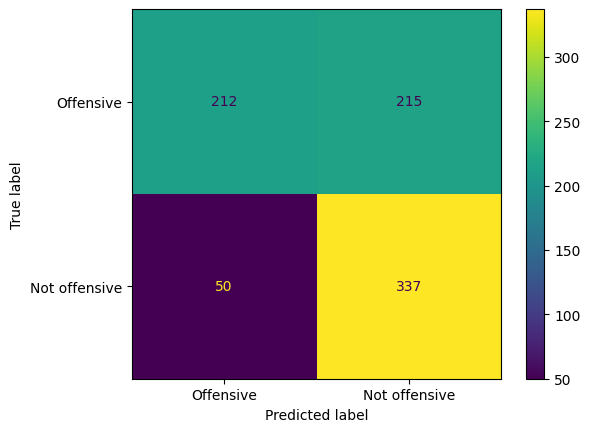

In [49]:
labels = ["Offensive", "Not offensive"]
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

print('Confusion matrix for the Naive Bayes')
disp.plot()

## The next few steps perform same calculations using Logistic Regression


In [50]:
# build naive bayes classification model
t = time()

logistic_regression_classifier = LogisticRegression()
logistic_regression_classifier.fit(X_train_tf, y_train)

# keep track of training time
training_time = time() - t
print("train time: %0.3fs" % training_time)

train time: 0.038s


In [52]:
# predict the new document from the testing dataset
t = time()
y_pred_lr = logistic_regression_classifier.predict(X_test_tf)

test_time = time() - t
print("test time:  %0.3fs" % test_time)

ml_metrics = mlu.calculate_ml_metrics(y_test.to_numpy(), y_pred_lr, False)

pp.pprint(ml_metrics)

print('F1', ml_metrics.calculate_f_score())

test time:  0.000s
MlMetric(accuracy=0.7174447174447175,
         precision=0.7260981912144703,
         recall=0.6938271604938272,
         specificity=0.7408312958435208,
         loss=None,
         F1=None,
         predictions=None,
         labels=None)
F1 0.7095959595959596


Confusion matrix for logistic regression


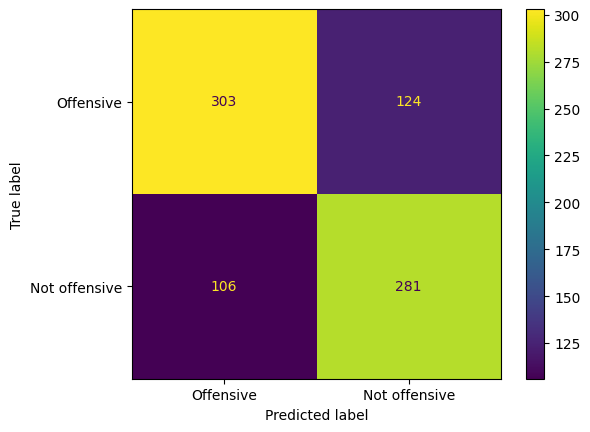

In [53]:
cm = confusion_matrix(y_test, y_pred_lr)
labels = ["Offensive", "Not offensive"]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
print('Confusion matrix for logistic regression')
disp.plot()